# W266 Final Project Modeling
In this notebook, I implement the fine-tuned BERT model described in *Twitch Emote Prediction: Extensions and Benchmarking using Transformers*.

## 1. Setup
First, import libraries & data

In [1]:
# Import libraries
from google.colab import files
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import nltk
from nltk.data import find

In [2]:
# Read the data
uploaded = files.upload()

Saving top_30_emotes.csv to top_30_emotes.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))
df.rename(columns={"label": "label_name"}, inplace=True)
df.head(5)

<ipython-input-3-5366ad058dd5>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))


,commenter_id,commenter_name,user_type,message_time,message_type,streamer,video_date,video_id,message_length,message,input,label_name
0,23261972.0,qrass,User,2023-03-11T18:05:21.218Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,3,no skipper stream Sadge,no skipper stream,Sadge
1,160455408.0,moby_drip,User,2023-03-11T18:05:42.405Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,3 second skippy stream Pog,3 second skippy stream,Pog
2,39897326.0,charmiee,User,2023-03-11T18:06:01.633Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,8,u got the wrong channel at first mate LUL,u got the wrong channel at first mate,LUL
3,115717981.0,just__ok,User,2023-03-11T18:06:31.622Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,Sadge not at streamer awards,not at streamer awards,Sadge
4,28841240.0,Karaszan,User,2023-03-11T18:06:53.793Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,10,Is it real this time? @sodapoppin :D No Stream...,Is it real this time? @sodapoppin :D No Stream...,Sadge


## Data Preprocessing
- Lower case text (already experimented with keeping case in BERT and it wasn't improving the performance, but could do further experimentation with extended vocabulary)
- String index labels
- Train/test & train/validation splits

In [4]:
emote_counts = df[['label_name']].groupby(['label_name'])['label_name'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

df = pd.merge(df, emote_counts, on="label_name")

In [5]:
# Lower case input column
df['input'] = df['input'].str.lower()

# String index the label names
le = LabelEncoder()
df['label'] = le.fit_transform(df['label_name'])

# You can reverse this encoding: le.inverse_transform([9, 10, 1, 2])
target_names = le.inverse_transform(range(30))
print(target_names)

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [6]:
messages = df.input
labels = df.label
# Split into train & test
train_texts, test_texts, train_labels, test_labels = train_test_split(messages, labels, test_size=0.2, random_state=123)
print(len(train_texts))
print(len(test_texts))

687016
171754


In [7]:
train_texts[:5]

321220     @kali8000, you dont have any points to roulette 
792127                               blahspam13,  hi bestie
343906     eu still awake  eu still awake  eu still awak...
823620     spam  this  static  to  help  fnatic   spam  ...
248424    bunch of little guys saying heavyweights get t...
Name: input, dtype: object

In [8]:
train_labels[:5]

321220     7
792127    29
343906     7
823620    13
248424    12
Name: label, dtype: int64

Let's explicitly set aside part of our training set for validation purposes.



In [9]:
# Validation split is about 85/15 split
valid_texts = train_texts[600000:] 
valid_labels = train_labels[600000:]
train_texts = train_texts[:600000]
train_labels = train_labels[:600000]

print(len(train_texts)) # Always 600,000
print(len(valid_texts)) # 87016

600000
87016


In [10]:
# Get the labels in a needed data format for validation
valid_labels = np.asarray(valid_labels)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [12]:
train_texts = list(train_texts)
test_texts = list(test_texts)
valid_texts = list(valid_texts)

## BERT Model

In [13]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.9 MB/s eta 0:00:00


In [14]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 

In [16]:
from transformers import BertTokenizer, TFBertModel

Let's pick our BERT model.  We'll start with the base BERT model and we'll use the uncased version since our data has been set to lower case. We already experimented with keeping case in our BERT and it wasn't improving the performance, but could do further experimentation in future work.

Notes: Keeping case in BERT model produces a lower accuracy when compared with the same parameters: Validation accuracy = 0.2136. Test accuracy = 0.2164

In [18]:
model_checkpoint = 'bert-base-uncased'

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
max_length = 32

Now we'll tokenize our three data slices.  This will take a minute or two.

In [20]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

Notice our input_ids for the first training record and their padding. The train_encodings also includes an array of token_type_ids and an attention_mask array. 

In [21]:
train_encodings.input_ids[:1]

<tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[  101,   137, 24181,  2646, 18910,  7629,   117,  1128,  1274,
         1204,  1138,  1251,  1827,  1106,   187,  6094, 21958,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>

Multiclass bert model characteristics:
* Each record can have one of 30 labels: n = the size of target_names.
* Hidden size layer of size 32
* Hidden layer makes use of the **pooler output** from BERT
* Use dropout
* Classification layer appropriately sized and use softmax non-linearity for multi-class.
* Loss metric is categorical cross entropy
* Training affects **all** of the layers in BERT


In [22]:
from tensorflow.keras.optimizers.legacy import Adam   # Needed to work

In [23]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 30,
                                 hidden_size = 201, 
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    bert_model = TFBertModel.from_pretrained(checkpoint)                                              

    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)
    pooler_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')


    return classification_model

In [24]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=30)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
pooler_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 32)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 32)]        0           []                               
 er)                                                                                              
                                                                                              

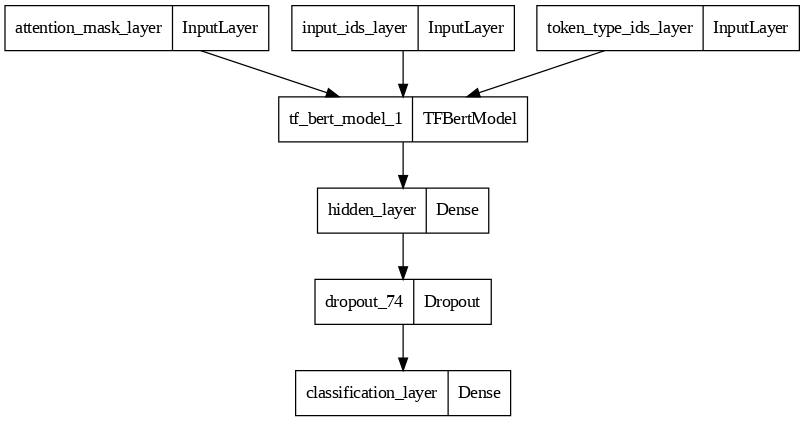

In [26]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [29]:
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  valid_labels),    
                                                  batch_size=32, 
                                                  epochs=1)  

18750/18750 [==============================] - 4243s 226ms/step - loss: 1.8103 - accuracy: 0.4581 - val_loss: 1.6104 - val_accuracy: 0.5060


Now we need to run evaluate against our fine-tuned model.  This will give us an overall accuracy based on the test set.

In [30]:
# batch=32, max length=32
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  test_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

5368/5368 [==============================] - 443s 82ms/step - loss: 1.6050 - accuracy: 0.5084
Test loss: 1.6049749851226807
Test accuracy: 0.5083957314491272


In [31]:
# Make predictions
predictions_model = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])

# Get highest probability in the distribution for each prediction and store in a tf.Tensor
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

5368/5368 [==============================] - 432s 80ms/step


<tf.Tensor: shape=(171754,), dtype=int64, numpy=array([ 9, 18,  5, ...,  3, 24, 12])>

There are two ways to see what's going on with our classifier.  Overall accuracy is interesting but it can be misleading.  We need to make sure that each of our categories' prediction performance is operating at an equal or higher level than the overall.

Here we'll use the classification report from scikit learn.  It expects two inputs as arrays.  One is the ground truth (y_true) and the other is the associated prediction (y_pred).  This is based on gethering all the predictions from our our test set.

In [32]:
print(classification_report(test_labels, predictions_model.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

          4Head       0.68      0.44      0.54      1916
         4Weird       0.64      0.40      0.49       928
          5Head       0.80      0.08      0.14      1019
          AYAYA       0.73      0.61      0.67      3555
     BibleThump       0.56      0.29      0.38      2838
       DansGame       0.57      0.33      0.42      1703
       FailFish       0.52      0.36      0.42      1507
    FeelsBadMan       0.88      0.82      0.85      7153
   FeelsGoodMan       0.89      0.86      0.88      5694
           KEKW       0.44      0.58      0.50     37165
          Kappa       0.75      0.03      0.05      5683
       Kreygasm       0.38      0.34      0.36      2239
            LUL       0.40      0.59      0.48     35572
    MorphinTime       0.99      0.97      0.98      3592
    NotLikeThis       0.27      0.16      0.20      3347
     PauseChamp       0.48      0.20      0.28      1782
      PepeLaugh       0.73    

Notes:
- Starts overfitting in the second epoch. Val accuracy goes from 0.45 to 0.22
- Not lower casing gives val accuracy of 0.2136. Test accuracy = 0.2164

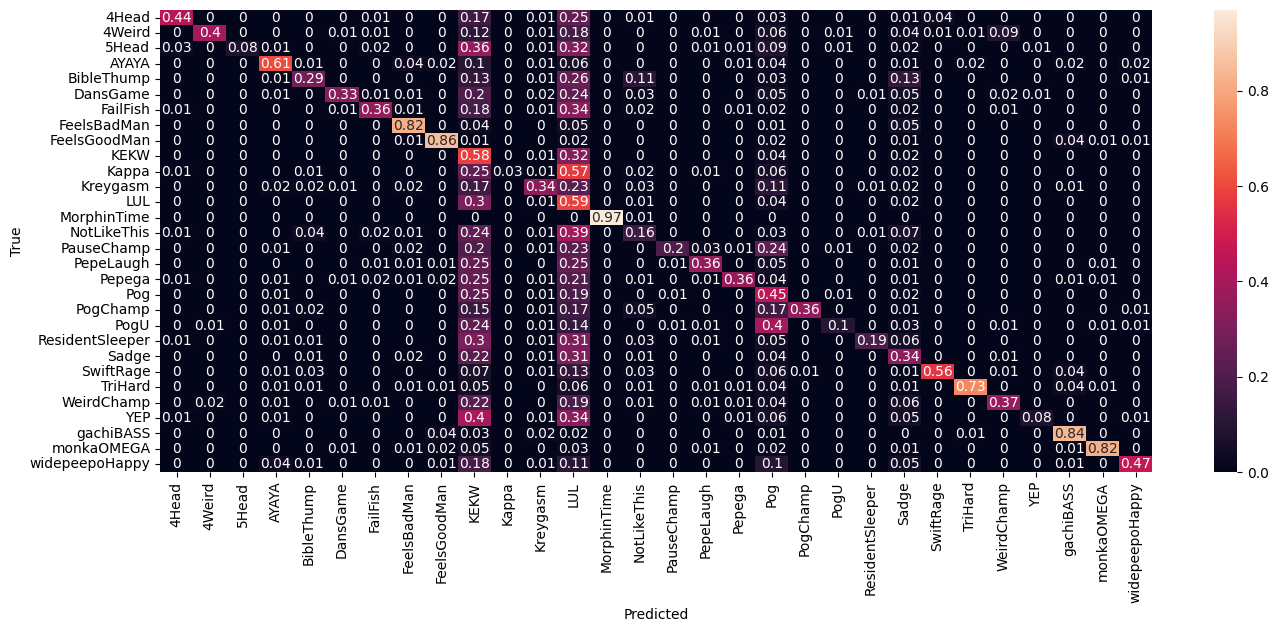

In [38]:
cm = tf.math.confusion_matrix(test_labels, predictions_model)
cm = np.around(cm/cm.numpy().sum(axis=1)[:, tf.newaxis], decimals=2)

plt.figure(figsize=(16,6))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [85]:
# Test some custom inputs into the model for model comparison

example = ['any second now']
example_encodings = bert_tokenizer(example, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
example_prediction = pooler_bert_model.predict([example_encodings.input_ids, example_encodings.token_type_ids, example_encodings.attention_mask])

example_prediction = tf.argmax(example_prediction , axis=-1)
example_prediction

le.inverse_transform(example_prediction)

1/1 [==============================] - 0s 111ms/step


array(['PauseChamp'], dtype=object)

## Misclassification Examples

We might be able to tell what happened from the confusion matrix, but it's also always a good idea to look at actual examples that were misclassified, to see if we can spot any patterns. We can also isolate more specific examples for each class of interest, Let's do that below.


In [42]:
# Make a vector the length of our test set, with 1 if the second model predicted the
# 9 class, and 0s otherwise
select_predictions = (predictions_model.numpy() == 9)

# Now only keep a 1 if that was not the correct label, i.e. it was a false positive
select_predictions = select_predictions * (test_labels != 9)


# Print out the original and clean text of the examples that met the above conditions
for i in np.where(select_predictions)[0][10:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = KEKW, Actual = AYAYA):
Text: g  e  n  g


Prediction = KEKW, Actual = Pog):
Text: disney plus kia 


Prediction = KEKW, Actual = monkaOMEGA):
Text: same plushy pile  same plushy pile  same plushy pile  same plushy pile  same plushy pile 


Prediction = KEKW, Actual = LUL):
Text: they teach you and i learn from you 


Prediction = KEKW, Actual = Sadge):
Text: lost to mechanics 


Prediction = KEKW, Actual = Pog):
Text: it might be a wr 


Prediction = KEKW, Actual = WeirdChamp):
Text: kevin is an incel 


Prediction = KEKW, Actual = DansGame):
Text: nerf river shen  not balanced 


Prediction = KEKW, Actual = LUL):
Text: i love your show family guy 


Prediction = KEKW, Actual = LUL):
Text: eu so quiet??  




In [44]:
select_predictions = (predictions_model.numpy() == 9)
select_predictions = select_predictions * (test_labels == 9)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = KEKW, Actual = KEKW):
Text: @claps_121 free lane for zeri and kassadin 


Prediction = KEKW, Actual = KEKW):
Text: fpx at worlds? 


Prediction = KEKW, Actual = KEKW):
Text: super meme team 


Prediction = KEKW, Actual = KEKW):
Text: gambling politics or zoomer 


Prediction = KEKW, Actual = KEKW):
Text: it's a sidequest 


Prediction = KEKW, Actual = KEKW):
Text: like in na 


Prediction = KEKW, Actual = KEKW):
Text: finn  losing to ornn


Prediction = KEKW, Actual = KEKW):
Text: true i can see that 


Prediction = KEKW, Actual = KEKW):
Text: korean learning book 


Prediction = KEKW, Actual = KEKW):
Text: ezreal so useless 




MorphinTime

In [43]:
select_predictions = (predictions_model.numpy() == 13)
select_predictions = select_predictions * (test_labels != 13)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = MorphinTime, Actual = Pog):
Text: lets goo fnc 


Prediction = MorphinTime, Actual = PogChamp):
Text: lets go g2 


Prediction = MorphinTime, Actual = LUL):
Text: lets go fnc  lets go fnc  lets go fnc 


Prediction = MorphinTime, Actual = Pog):
Text: lets go g2 


Prediction = MorphinTime, Actual = Kappa):
Text: lets go fnatic 


Prediction = MorphinTime, Actual = PogU):
Text: lets go g2 


Prediction = MorphinTime, Actual = Pog):
Text: lets go boaster  lets go boaster  lets go boaster  lets go boaster  lets go boaster 


Prediction = MorphinTime, Actual = Pog):
Text: lets go g2  lets go g2  lets go g2 


Prediction = MorphinTime, Actual = AYAYA):
Text: gg lets goggogogogoggo!! fnc fnc    fnc  


Prediction = MorphinTime, Actual = Pog):
Text: lets go g2 




In [45]:
select_predictions = (predictions_model.numpy() == 13)
select_predictions = select_predictions * (test_labels == 13)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  support  fnatic  spam  this  static  to  support  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  help  fnatic  spam  this  static  to  help  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  support  fnatic  spam  this  static  to  support  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  help  fnatic  spam  this  static  to  help  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text: spam  this  static  to  help  fnaticspam  this  static  to  help  fnatic


Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  help  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text:  spam  this  static  to  help  fnatic   spam  this  static  to  help  fnatic 


Prediction = MorphinTime, Actual = MorphinTime):
Text: spam  this  static  to  support  fna

LUL

In [48]:
select_predictions = (predictions_model.numpy() == 12)
select_predictions = select_predictions * (test_labels != 12)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = LUL, Actual = PepeLaugh):
Text: no ad for u 


Prediction = LUL, Actual = DansGame):
Text: why are we watching this and not the ping pong? 


Prediction = LUL, Actual = YEP):
Text:  good stuff regardless


Prediction = LUL, Actual = PepeLaugh):
Text:  surely no cancellations


Prediction = LUL, Actual = KEKW):
Text: @ragnarosthefacelord it took the same for hollow knight ? 


Prediction = LUL, Actual = KEKW):
Text: og kicked ana for this ? 


Prediction = LUL, Actual = YEP):
Text: oh i thought that was the commentator mimi oops 


Prediction = LUL, Actual = KEKW):
Text: i like new picks but at the same time mf 


Prediction = LUL, Actual = Kappa):
Text: you gotta sub for a forehead reveal 


Prediction = LUL, Actual = Sadge):
Text: there's no music like in rollercoaster tycoon 




In [50]:
select_predictions = (predictions_model.numpy() == 12)
select_predictions = select_predictions * (test_labels == 12)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = LUL, Actual = LUL):
Text: @usdaprimealpha i take it now you just watch someone else play it instead? 


Prediction = LUL, Actual = LUL):
Text: asmongold 8 v emi 12* asmon making a comeback and should roast emi 


Prediction = LUL, Actual = LUL):
Text: dyrachyo so bad doesnt even press rot 


Prediction = LUL, Actual = LUL):
Text: all over a picture 


Prediction = LUL, Actual = LUL):
Text: @dcdfuzed "badum tis" 


Prediction = LUL, Actual = LUL):
Text: bro is 400 pounds 


Prediction = LUL, Actual = LUL):
Text: @keidootv just doesnt like diablo 


Prediction = LUL, Actual = LUL):
Text: lil bro is fuming 


Prediction = LUL, Actual = LUL):
Text: riki over here playing constructed 


Prediction = LUL, Actual = LUL):
Text: his smile tho    




YEP (worst f1 score)

In [51]:
select_predictions = (predictions_model.numpy() == 26)
select_predictions = select_predictions * (test_labels != 26)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = YEP, Actual = KEKW):
Text: nationalization would help with cost cutting because you wouldnt have to contract out to private corpos 


Prediction = YEP, Actual = Pog):
Text:  beat the dicks, toby


Prediction = YEP, Actual = 5Head):
Text: ignorance is bliss 


Prediction = YEP, Actual = KEKW):
Text: i have my cock in my left hand 


Prediction = YEP, Actual = WeirdChamp):
Text:  hes lagging oyu asshole


Prediction = YEP, Actual = Sadge):
Text: dogs do that, they take distance so their family doesnt suffer 


Prediction = YEP, Actual = monkaOMEGA):
Text:  check your cock its gone


Prediction = YEP, Actual = Pog):
Text:  thats why hes the goat


Prediction = YEP, Actual = 4Head):
Text: dick all in yo stomach 


Prediction = YEP, Actual = Pog):
Text: because it is fucking amazing that's why 




In [52]:
select_predictions = (predictions_model.numpy() == 26)
select_predictions = select_predictions * (test_labels == 26)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = YEP, Actual = YEP):
Text: w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch w!  watch


Prediction = YEP, Actual = YEP):
Text:  i'll show them a cock grave 


Prediction = YEP, Actual = YEP):
Text:  thats bill tin megalul


Prediction = YEP, Actual = YEP):
Text: hating is easy 


Prediction = YEP, Actual = YEP):
Text:  thats a timing megalul 󠀀


Prediction = YEP, Actual = YEP):
Text: someone say cock 


Prediction = YEP, Actual = YEP):
Text: , that's cum sade


Prediction = YEP, Actual = YEP):
Text:  breaks are good


Prediction = YEP, Actual = YEP):
Text: megalul  thats a bill tin 😂  thats a bill tin


Prediction = YEP, Actual = YEP):
Text: homelessness is tramatic 




Pog

In [53]:
select_predictions = (predictions_model.numpy() == 18)
select_predictions = select_predictions * (test_labels != 18)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = Pog, Actual = FeelsBadMan):
Text: faker  end of an era


Prediction = Pog, Actual = PepeLaugh):
Text: 15 hour stream 


Prediction = Pog, Actual = NotLikeThis):
Text: figuratively777 subscribed with prime. they've subscribed for 10 months! critrolestorm 


Prediction = Pog, Actual = Sadge):
Text:   dinosaurs   dinosaurs   dinosaurs   dinosaurs   dinosaurs   dinosaurs   dinosaurs   dinosaurs   dinosaurs


Prediction = Pog, Actual = WeirdChamp):
Text: open a hosipital    open a hosipital    open a hosipital    open a hosipital    open a hosipital    open a hosipital    open a hosipital  


Prediction = Pog, Actual = YEP):
Text: an expansion dlc 


Prediction = Pog, Actual = monkaOMEGA):
Text:  this could be it


Prediction = Pog, Actual = PogU):
Text: lord of the rings 


Prediction = Pog, Actual = PogU):
Text: penis rocket pcs 


Prediction = Pog, Actual = Kreygasm):
Text: ezlivi my idol   so good 




In [54]:
select_predictions = (predictions_model.numpy() == 18)
select_predictions = select_predictions * (test_labels == 18)

for i in np.where(select_predictions)[0][:10]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = Pog, Actual = Pog):
Text: free curse rooms 


Prediction = Pog, Actual = Pog):
Text: we love destiny  we love destiny  we love destiny  we love destiny  we love destiny  we love destiny  we love destiny  we love destiny 


Prediction = Pog, Actual = Pog):
Text: leave penta  leave penta  leave penta  aintnoway leave penta  leave penta  leave penta  aintnoway


Prediction = Pog, Actual = Pog):
Text: +1 quadrillion veiwers 


Prediction = Pog, Actual = Pog):
Text: instant triple buyback 


Prediction = Pog, Actual = Pog):
Text:  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller  @dreamerstorryteller


Prediction = Pog, Actual = Pog):
Text: congrats on the new place. looks awesome 


Prediction = Pog, Actual = Pog):
Text: 250k on win 


Prediction = Pog, Actual = Pog):
Text: world first death 


Prediction = Po

In [55]:
select_predictions = (predictions_model.numpy() == 18)
select_predictions = select_predictions * (test_labels == 18)

for i in np.where(select_predictions)[0][10:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = Pog, Actual = Pog):
Text: qb club 98 


Prediction = Pog, Actual = Pog):
Text: world war wick 


Prediction = Pog, Actual = Pog):
Text: we're on the board 


Prediction = Pog, Actual = Pog):
Text: 3 hour stream mark 


Prediction = Pog, Actual = Pog):
Text: new jerma lore 


Prediction = Pog, Actual = Pog):
Text: johnny depp from wish.com 


Prediction = Pog, Actual = Pog):
Text:  the dad is back


Prediction = Pog, Actual = Pog):
Text:  i was here


Prediction = Pog, Actual = Pog):
Text: i was here   


Prediction = Pog, Actual = Pog):
Text: moment nft  moment nft  moment nft  moment nft  moment nft  moment nft 




AYAYA

In [80]:
select_predictions = (predictions_model.numpy() == 3)
select_predictions = select_predictions * (test_labels != 3)

for i in np.where(select_predictions)[0][10:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = AYAYA, Actual = DansGame):
Text: move shit  eew


Prediction = AYAYA, Actual = Kreygasm):
Text: omg tensai is god 


Prediction = AYAYA, Actual = YEP):
Text: @vis9ns ayaya in bed and youll win with every guy 


Prediction = AYAYA, Actual = PepeLaugh):
Text: i heard it 


Prediction = AYAYA, Actual = Pog):
Text: womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp  womp womp 


Prediction = AYAYA, Actual = BibleThump):
Text: i love uuu <3 


Prediction = AYAYA, Actual = PogU):
Text:  cute outfit rae!


Prediction = AYAYA, Actual = monkaOMEGA):
Text:  i heard it  i heard it  i heard it  i heard it


Prediction = AYAYA, Actual = YEP):
Text:  🫛 🥜 🚀 nyannswash


Prediction = AYAYA, Actual = Kreygasm):
Text: let us sup 




In [79]:
select_predictions = (predictions_model.numpy() == 3)
select_predictions = select_predictions * (test_labels == 3)

for i in np.where(select_predictions)[0][10:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = AYAYA, Actual = AYAYA):
Text: rogue this  fnatic that  i just want  a cute chat 


Prediction = AYAYA, Actual = AYAYA):
Text:   ayayo   ayayo   ayayo


Prediction = AYAYA, Actual = AYAYA):
Text:  gomensai okasan ehehe  gomensai okasan ehehe  gomensai okasan ehehe  gomensai okasan ehehe


Prediction = AYAYA, Actual = AYAYA):
Text: @mister_doktor,  / <3


Prediction = AYAYA, Actual = AYAYA):
Text: moshi moshi 📞  running low on cuties 📞  need backup 📞  arigato 📞 


Prediction = AYAYA, Actual = AYAYA):
Text: cute team  clap


Prediction = AYAYA, Actual = AYAYA):
Text:  <3 eep <3 


Prediction = AYAYA, Actual = AYAYA):
Text: nyanpls   nyanpls  nyanpls  nyanpls  nyanpls  nyanpls  nyanpls  nyanpls  nyanpls 


Prediction = AYAYA, Actual = AYAYA):
Text:  we won we won


Prediction = AYAYA, Actual = AYAYA):
Text:  investment in waifus




POGU

In [81]:
select_predictions = (predictions_model.numpy() == 20)
select_predictions = select_predictions * (test_labels == 20)

for i in np.where(select_predictions)[0][10:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = PogU, Actual = PogU):
Text: league of their own 2023  league of their own 2023  league of their own 2023  league of their own 2023  league of their own 2023  league of their own 2023 


Prediction = PogU, Actual = PogU):
Text: ls saved fnc 


Prediction = PogU, Actual = PogU):
Text: themajorityreport just raided with 46 viewers! 


Prediction = PogU, Actual = PogU):
Text:  play it  play it  play it


Prediction = PogU, Actual = PogU):
Text: house tour at 15000  house tour at 15000  house tour at 15000  house tour at 15000  house tour at 15000  house tour at 15000  house tour at 15000 


Prediction = PogU, Actual = PogU):
Text:  saved  saved  saved  saved


Prediction = PogU, Actual = PogU):
Text:  league of their own 2023  league of their own 2023  league of their own 2023  league of their own 2023


Prediction = PogU, Actual = PogU):
Text:  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  steve aoki  s

In [83]:
select_predictions = (predictions_model.numpy() == 20)
select_predictions = select_predictions * (test_labels != 20)

for i in np.where(select_predictions)[0][0:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = PogU, Actual = Sadge):
Text: he extracted  he extracted  he extracted  he extracted  he extracted 


Prediction = PogU, Actual = Pog):
Text:  play rocket league!!


Prediction = PogU, Actual = Pog):
Text: ls saved fnc 


Prediction = PogU, Actual = LUL):
Text: justin tryin to teach boomers how to play rocket league  justin tryin to teach boomers how to play rocket league  justin tryin to teach boomers how to play rocket league  justin tryin to teach boomers how to play rocket league 


Prediction = PogU, Actual = PepeLaugh):
Text: didnt save  didnt save  didnt save  didnt save  didnt save  .


Prediction = PogU, Actual = ResidentSleeper):
Text: pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded  pre recorded 


Prediction = PogU, Actual = Pog):
Text: ls saved fnatic 


Prediction = PogU, Actual = gachiBASS):
Text:  dance  dance  dance  dance


Prediction = Po

In [31]:
select_predictions = (predictions_model.numpy() == 22)
select_predictions = select_predictions * (test_labels == 22)

for i in np.where(select_predictions)[0][0:20]:
      print('Prediction = %s, Actual = %s):\nText: %s\n\n' %
            (target_names[predictions_model[i]],
            target_names[test_labels[i]],
            test_texts[i][:1000].replace('\n', ' ')))

Prediction = Sadge, Actual = Sadge):
Text:  im sorry man, hope whatver it is thats going on gets better or that you have people around you to help


Prediction = Sadge, Actual = Sadge):
Text: i miss moon2windblowingsheets 


Prediction = Sadge, Actual = Sadge):
Text: i cant gamba 


Prediction = Sadge, Actual = Sadge):
Text: @tengo_6  wrangler's being fired shortly.


Prediction = Sadge, Actual = Sadge):
Text: ellie so mean 


Prediction = Sadge, Actual = Sadge):
Text: @tmcflurry now i can't work in the kitchen 


Prediction = Sadge, Actual = Sadge):
Text: 📜✍️  𝓓𝓮𝓪𝓻 𝓓𝓲𝓪𝓻𝔂, 𝓽𝓱𝓮 𝔂𝓮𝓪𝓻 𝓲𝓼 2047, 𝓕𝓸𝓻𝓼𝓮𝓷 𝓴𝓮𝓮𝓹𝓼 𝓼𝓪𝔂𝓲𝓷𝓰 𝓽𝓸 𝓱𝓲𝓼 𝓬𝓵𝓸𝓷𝓮𝓼: "𝓣𝓸𝓭𝓪𝔂 𝓲𝓼 𝓽𝓱𝓮 𝓭𝓪𝔂", 𝓸𝓿𝓮𝓻 𝓪𝓷𝓭 𝓸𝓿𝓮𝓻. 𝓑𝓾𝓽 𝓱𝓮 𝓭𝓸𝓮𝓼𝓷'𝓽 𝓮𝓿𝓮𝓷 𝓹𝓵𝓪𝔂 𝓜𝓲𝓷𝓮𝓬𝓻𝓪𝓯𝓽 𝓪𝓷𝔂𝓶𝓸𝓻𝓮.ů§


Prediction = Sadge, Actual = Sadge):
Text: hes retiring \


Prediction = Sadge, Actual = Sadge):
Text:  agree sadly, he deserves it


Prediction = Sadge, Actual = Sadge):
Text: i got nuked off twitter 


Prediction = Sadge, Actual = Sadge):
Text: me when i am the am ruined by experie